# XGBoost tuning 

Throughout the following exercises, we'll learn to use Python to construct and interpret an XGBoost classification model using the XGBoost modeling library.

## Review

This notebook is a continuation of the bank churn project. Below is a recap of the considerations and decisions that we've already made.

>  **Modeling objective:** To predict whether a customer will churn&mdash;a binary classification task


>  **Target variable:** `Exited` column&mdash;0 or 1

>  **Class balance:** The data is imbalanced 80/20 (not churned/churned), but we will not perform class balancing.

>  **Primary evaluation metric:** F1 score

>  **Modeling workflow and model selection:** The champion model will be the model with the best validation F1 score. Only the champion model will be used to predict on the test data.

In [1]:
%%time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

import pickle

CPU times: total: 2.64 s
Wall time: 7.05 s


In [3]:
# Read in the dataset
df_original= pd.read_csv(r'C:\Users\user\Desktop\Course 6\Churn_Modelling.csv')
df_original.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df_original.shape

(10000, 14)

In [5]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [7]:
df_original.describe

<bound method NDFrame.describe of       RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
0             1    15634602   Hargrave          619    France  Female   42   
1             2    15647311       Hill          608     Spain  Female   41   
2             3    15619304       Onio          502    France  Female   42   
3             4    15701354       Boni          699    France  Female   39   
4             5    15737888   Mitchell          850     Spain  Female   43   
...         ...         ...        ...          ...       ...     ...  ...   
9995       9996    15606229   Obijiaku          771    France    Male   39   
9996       9997    15569892  Johnstone          516    France    Male   35   
9997       9998    15584532        Liu          709    France  Female   36   
9998       9999    15682355  Sabbatini          772   Germany    Male   42   
9999      10000    15628319     Walker          792    France  Female   28   

      Tenure    Balance  NumO

## Feature engineering

### Feature selection

In this step, we'll prepare the data for modeling, though the steps of feature engineering have been completed in a previous lab.  Notice from above that there are a number of columns that we wouldn't expect to offer any predictive signal to the model. These columns include `RowNumber`, `CustomerID`, and `Surname`. We'll drop these columns so they don't introduce noise to our model.  

We'll also drop the `Gender` column, because we don't want our model to make predictions based on gender.

In [8]:
# Drop sensitive column
churn_df = df_original.drop(['RowNumber', 'CustomerId', 'Surname', 'Gender'], 
                            axis=1)
churn_df.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,41,1,83807.86,1,0,1,112542.58,0
2,502,France,42,8,159660.80,3,1,0,113931.57,1
3,699,France,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,43,2,125510.82,1,1,1,79084.10,0


### Feature transformation

Next, we'll dummy encode the `Geography` variable, which is categorical.

In [9]:
# Dummy encode categorical variables
churn_df2 = pd.get_dummies(churn_df, drop_first='True')
churn_df2.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1


## Split the data

We'll split the data into features and target variable, and into training data and test data using the `train_test_split()` function. 

In [10]:
# Define the y (target) variable
y = churn_df2["Exited"]

# Define the X (predictor) variables
X = churn_df2.copy()
X = X.drop("Exited", axis = 1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

## Modeling

### Cross-validated hyperparameter tuning

The cross-validation process is the same as it was for the decision tree and random forest models. The only difference is that we're tuning different hyperparameters now. The steps are included below as a review. 

1. Instantiate the classifier (and set the `random_state`). Note here that we've included a parameter called `objective` whose value is `binary:logistic`. This means that the model is performing a binary classification task that outputs a logistic probability. The objective would be different for different kinds of problems—for instance, if we were trying to predict more than two classes or performing a linear regression on continuous data.

2. Create a dictionary of hyperparameters to search over.

3. Create a dictionary of scoring metrics to capture. 

4. Instantiate the `GridSearchCV` object. Pass as arguments:
  - The classifier (`xgb`)
  - The dictionary of hyperparameters to search over (`cv_params`)
  - The dictionary of scoring metrics (`scoring`)
  - The number of cross-validation folds you want (`cv=5`)
  - The scoring metric that you want GridSearch to use when it selects the "best" model (i.e., the model that performs best on average over all validation folds) (`refit='f1'`)

5. Fit the data (`X_train`, `y_train`) to the `GridSearchCV` object (`xgb_cv`)

In [12]:
xgb= XGBClassifier(objective= 'binary:logistic', random_state=0)

cv_params= {'max_depth': [4,5,6,7,8], 
             'min_child_weight': [1,2,3,4,5],
             'learning_rate': [0.1, 0.2, 0.3],
             'n_estimators': [75, 100, 125]
           } 
scoring= {'accuracy', 'precision', 'recall', 'f1'}

xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='f1')

In [13]:
%%time
#xgb_cv.fit(X_train, y_train)

CPU times: total: 32min 41s
Wall time: 18min 11s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [1, 2, 3, 4, 5],
                         'n_estimators': [75, 100, 125]},
             refit='f1', scoring={'f1', 'recall', 'accuracy', 'precision'})

## Pickle the model to increase efficiency

In [15]:
with open ('xgb_cv_pickle', 'wb') as to_write:
    pickle.dump(xgb_cv, to_write)

In [20]:
with open (r'C:\Users\user\Downloads\xgb_cv_pickle','rb') as to_read:
    xgb_cv= pickle.load(to_read)

Let's check our model's score and compare it to our random forest's score on the same cross-validated train data. We'll have to import the pickled random forest model.

In [ ]:
with open(r'C:\Users\user\Desktop\Course 6\pickle and results\rf_cv_model.pickle', 'rb') as to_read:
    rf_cv= pickle.load(to_read)

In [22]:
rf_cv.fit(X_train, y_train)

print('F1 score random forest CV: ', rf_cv.best_score_)
print('F1 score XGB CV: ', xgb_cv.best_score_)

F1 score random forest CV:  0.580528563620339
F1 score XGB CV:  0.5838246640284066


We'll use the same helper function we used in previous notebooks to organize our results into a dataframe.

In [23]:
def make_results(model_name, model_object):
    '''
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.
  
    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean F1 score across all validation folds.  
    '''

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = table.append({'Model': model_name,
                        'F1': f1,
                        'Recall': recall,
                        'Precision': precision,
                        'Accuracy': accuracy
                        },
                        ignore_index=True
                       )
  
    return table

In [24]:
# Create xgb model results table
xgb_cv_results = make_results('XGBoost CV', xgb_cv)
xgb_cv_results

C:\Users\user\AppData\Local\Temp\ipykernel_4292\2409802599.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name,


,Model,F1,Recall,Precision,Accuracy
0,XGBoost CV,0.583825,0.482342,0.744089,0.8604


## Model selection and final results

In [25]:
# Predict on test data
xgb_cv_preds = xgb_cv.predict(X_test)
print('F1 score final XGB model: ', f1_score(y_test, xgb_cv_preds))
print('Recall score final XGB model: ', recall_score(y_test, xgb_cv_preds))
print('Precision score final XGB model: ', precision_score(y_test, xgb_cv_preds))
print('Accuracy score final XGB model: ', accuracy_score(y_test, xgb_cv_preds))

F1 score final XGB model:  0.6059171597633135
Recall score final XGB model:  0.5029469548133595
Precision score final XGB model:  0.7619047619047619
Accuracy score final XGB model:  0.8668


Wow! The final model performed even better on the test data than it did on the validation data. This is quite unusual. Typically, performance on test data is a little worse than on validation data. But the difference here is small, so it's not cause for concern. 

Let's check our confusion matrix.

### Confusion matrix

In [31]:
# Create helper function to plot confusion matrix
def conf_matrix_plot(model, x_data, y_data):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate). 
    Returns a plot of confusion matrix for predictions on y data.
    ''' 
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
  
    disp.plot()
    plt.show()

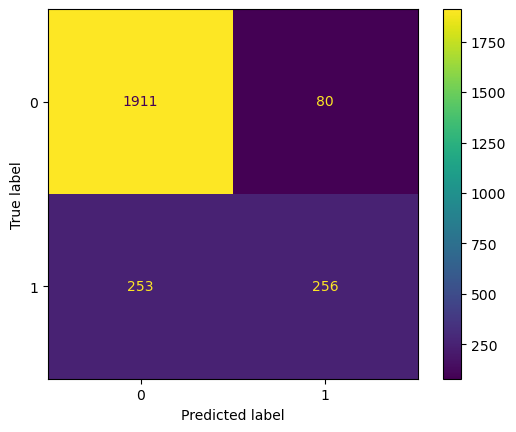

In [32]:
conf_matrix_plot(xgb_cv, X_test, y_test)

From the 2,500 people in our test data, there are 509 customers who left the bank. Of those, our model captures 256. The confusion matrix indicates that, when the model makes an error, it’s usually a Type II error&mdash;it gives a false negative by failing to predict that a customer will leave. On the other hand, it makes far fewer Type I errors, which are false positives.

Ultimately, whether these results are acceptable depends on the costs of the measures taken to prevent a customer from leaving versus the value of retaining them. In this case, bank leaders may decide that they’d rather have more true positives, even if it means also capturing significantly more false positives. If so, perhaps optimizing the models based on their F1 scores is insufficient. Maybe we’d prioritize a different evaluation metric. 

One way to modify the decision-making without retraining the model is to adjust the threshold at which the model predicts a positive response. In other words, the model determines a probability that a given customer will churn. By default, if that probability is ≥ 0.50, then the model will label that customer as churned. Probabilities of < 0.50 would designate a non-responder. But it's possible to adjust this decision threshold. For instance, if we set the threshold to 0.25, then the model would label customers with predicted probabilities ≥ 0.25 as churned, and those with probabilities < 0.25 as not churned. This would increase the recall of the model, but decrease the accuracy.


### Feature importance

<Figure size 800x600 with 0 Axes>

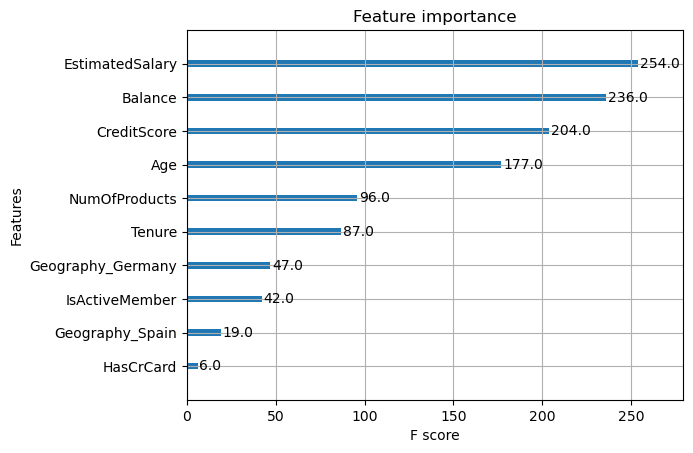

In [63]:
plot_importance(xgb_cv.best_estimator_);

This tells us that the four most important features used by our model were `EstimatedSalary`, `Balance`, `CreditScore`, and `Age`. This is very useful information.


## A reminder to data professionals about modeling trade-offs;

Remember, the decision to use only the champion model to predict on the test data comes with a trade-off. The benefit is that we get a true idea of how we'd expect the model to perform on new, unseen data. The cost of this decision is that, by using the validation scores to both tune hyperparamters _and_ select the champion model, we run the risk of selecting the model that most overfit the validation data. 

Alternatively, we could have selected our champion model by using all of our tuned models to predict on the test data and choosing the one that performed best. That also would have come with a trade-off. There wouldn't be as much risk of overfitting to the validation data, but by using the test data to select our champion model, we wouldn't get a truly objective idea of how the model would perform on new, unseen data. We would need a new dataset for that, which means we would have had to set more data aside at the beginning, resulting in less data to use to train the model. 

With sufficient data, a more rigorous approach would be:

1. Split the data into training, validation, and test sets
2. Tune hyperparameters using cross-validation on the training set
3. Use _all_ tuned models to predict on the validation set
4. Select a champion model based on performance on the validation set
5. Use champion model alone to predict on test data

Every modeling decision comes with a trade-off. What's most important is that you're aware of the trade-offs and apply the best reasoning to the task at hand.

